In [36]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV, cross_val_score

## Загружаем и готовим данные

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
df = pd.read_csv(url, header=None)

In [5]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
le.transform(['M', 'B'])

array([1, 0])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

## Создаём пайплайн для логистической регрессии со стандартизацией и сжатием

In [14]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(solver='liblinear', random_state=1)),
                   ])
pipe_lr.fit(X_train, y_train)
print('Pipeline test score: {:.3f}'.format(pipe_lr.score(X_test, y_test)))

Pipeline test score: 0.947


## Рассмотрим кривые обучения

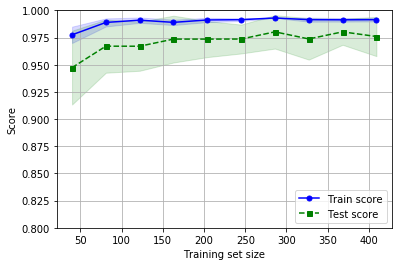

In [23]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='liblinear',
                                               penalty='l2',
                                               random_state=1)),
                   ])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(.1, 1., 10),
                                                        cv=10,
                                                        n_jobs=4)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Train score')
plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=.15, color='blue')

plt.plot(train_sizes, test_mean,
         linestyle='--',
         color='green', marker='s',
         markersize=5, label='Test score')
plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=.15, color='green')

plt.grid()
plt.xlabel('Training set size')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim([.8, 1.])
plt.show()

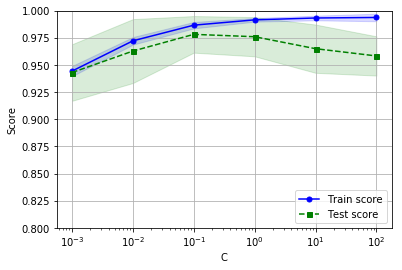

In [27]:
param_range = [.001, .01, .1, 1., 10., 100.]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='clf__C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Train score')
plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=.15, color='blue')

plt.plot(param_range, test_mean,
         color='green', marker='s', linestyle='--',
         markersize=5, label='Test score')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('C')
plt.ylabel('Score')
plt.ylim([.8, 1.])
plt.show()

In [29]:
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1)),
                   ])
param_range = [.0001, .001, .01, .1, 1., 10., 100., 1000.,]
param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=4)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [33]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
'Test score {:.3f}'.format(clf.score(X_test, y_test))

'Test score 0.965'

## Вложенная перекрестная проверка

In [35]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=4)
scores = cross_val_score(gs, 
                         X_train, 
                         y_train, 
                         scoring='accuracy', 
                         cv=5)
'Cross val score: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores))

'Cross val score: 0.965 +/- 0.025'

In [40]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=11),
                  param_grid=[
                      {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}
                  ],
                  scoring='accuracy',
                  cv=2,
                  n_jobs=4)
scores = cross_val_score(gs, 
                         X_train, 
                         y_train, 
                         scoring='accuracy', 
                         cv=5)
'Cross val score: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores))

'Cross val score: 0.921 +/- 0.020'

## Метрики качества

In [41]:
from sklearn.metrics import confusion_matrix

In [43]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[71,  1],
       [ 2, 40]])

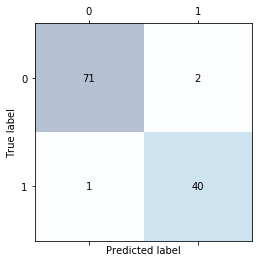

In [45]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=i, y=j,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

$ ERR = \frac{FP + FN}{FP + FN + TP + TN} $ <br/><br/>
$ ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR $ <br/><br/>
$ FPR = \frac{FP}{N} = \frac{FP}{FP + TN} $ <br/><br/>
$ TPR = \frac{TP}{P} = \frac{TP}{FN + TP} $ <br/><br/>
Precision: $ PRE = \frac{TP}{TP + FP} $ <br/><br/>
Recall: $ REC = TPR = \frac{TP}{FN + TP} $ <br/><br/>
$ F1 = 2 \frac{PRE \times REC}{PRE + REC} $